In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'

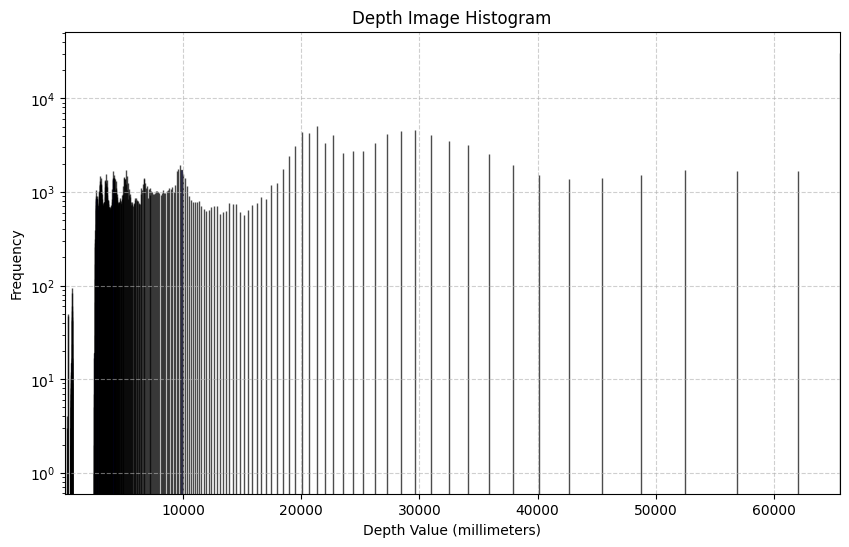

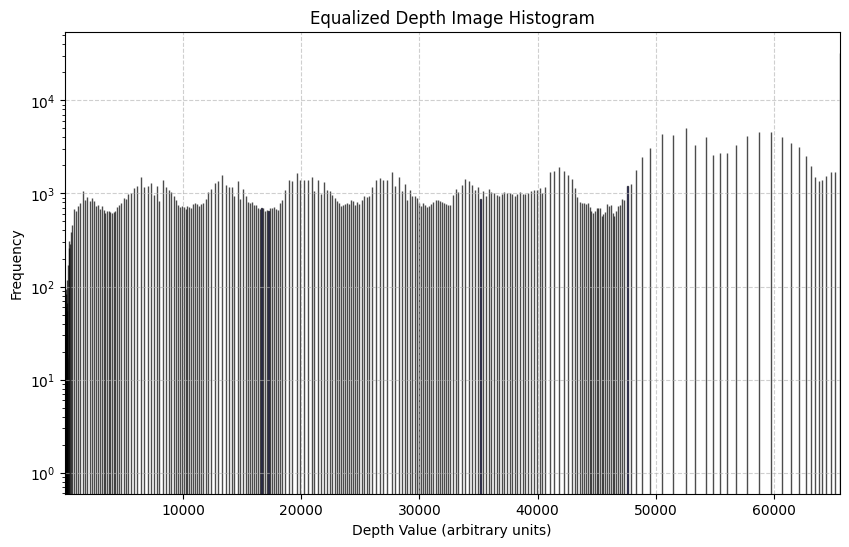

In [1]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal, equalize_histogram

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'


# iterate over all the videos inside the output path
for video_folder in os.listdir(OUTPUT_PATH):
    for frame_fn in os.listdir(os.path.join(OUTPUT_PATH, video_folder, 'depth')):
        # only process the multiples of 10 plus 1
        if (int(frame_fn.split('.')[0]) - 1) % 10 != 0:
            continue

        if int(frame_fn.split('.')[0]) < 40:
            continue
        
        # read the frame
        frame = cv.imread(os.path.join(OUTPUT_PATH, video_folder, 'depth', frame_fn), cv.IMREAD_UNCHANGED)
        
        # plot the histogram of values of the image
        depth_values = frame.flatten()

        # Calculate histogram (ignoring zero values, if desired)
        histogram, bin_edges = np.histogram(depth_values[depth_values > 0], bins=range(0, 65536), density=False)

        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], histogram, width=1, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Depth Image Histogram')
        plt.xlabel('Depth Value (millimeters)')
        plt.ylabel('Frequency')
        plt.xlim([1, 65535])  # Ignore zero values for better visualization
        plt.yscale('log')  # Use a logarithmic scale for better visualization of distributions
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        # equalize the histogram of the image
        eq_frame = equalize_histogram(frame)
        eq_depth_values = eq_frame.flatten()
        eq_histogram, eq_bin_edges = np.histogram(eq_depth_values[eq_depth_values > 0], bins=range(0, 65536), density=False)
        plt.figure(figsize=(10, 6))
        plt.bar(eq_bin_edges[:-1], eq_histogram, width=1, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Equalized Depth Image Histogram')
        plt.xlabel('Depth Value (arbitrary units)')
        plt.ylabel('Frequency')
        plt.xlim([1, 65535])
        plt.yscale('log')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        break
    break

In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'

# iterate over all the videos inside the output path
for video_folder in os.listdir(OUTPUT_PATH):
    for frame_fn in os.listdir(os.path.join(OUTPUT_PATH, video_folder, 'depth')):
        # only process the multiples of 10 plus 1
        # if (int(frame_fn.split('.')[0]) - 1) % 10 != 0:
        #     continue

        # if int(frame_fn.split('.')[0]) < 40:
        #     continue
        
        # read the frame
        frame = cv.imread(os.path.join(OUTPUT_PATH, video_folder, 'depth', frame_fn), cv.IMREAD_UNCHANGED)
        
        # generate the normal map from the depth map
        start = time()
        normal = depth_to_normal(frame)
        print(f'Processing time {time()-start} ms')

        cv.imshow('depth', frame)
        cv.imshow('normal', normal)
        cv.waitKey(0)
        break
        

Processing time 0.05012106895446777 ms
Processing time 0.039064884185791016 ms
Processing time 0.03509020805358887 ms
Processing time 0.03116583824157715 ms
Processing time 0.02684926986694336 ms
Processing time 0.027695178985595703 ms
Processing time 0.031199216842651367 ms
Processing time 0.03464865684509277 ms
Processing time 0.03232121467590332 ms
Processing time 0.02982640266418457 ms
Processing time 0.03534364700317383 ms
Processing time 0.03257322311401367 ms
Processing time 0.02828216552734375 ms
Processing time 0.029314041137695312 ms
Processing time 0.03143572807312012 ms
Processing time 0.025720834732055664 ms
Processing time 0.0313420295715332 ms
Processing time 0.033356428146362305 ms
Processing time 0.03258156776428223 ms
Processing time 0.0328214168548584 ms
Processing time 0.033141136169433594 ms
Processing time 0.03192710876464844 ms
Processing time 0.030646562576293945 ms
Processing time 0.03156280517578125 ms
Processing time 0.03318524360656738 ms
Processing time 0.0

In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal, depth_to_jet, equalize_histogram

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'

# iterate over all the videos inside the output path
for video_folder in os.listdir(OUTPUT_PATH):
    for frame_fn in os.listdir(os.path.join(OUTPUT_PATH, video_folder, 'depth')):
        # only process the multiples of 10 plus 1
        # if (int(frame_fn.split('.')[0]) - 1) % 10 != 0:
        #     continue

        # if int(frame_fn.split('.')[0]) < 40:
        #     continue
        
        # only process the frame if video is 20200807061001 and frame is 000031
        if video_folder != '20200807061001' or frame_fn != '000031.png':
            continue
        # read the frame
        frame = cv.imread(os.path.join(OUTPUT_PATH, video_folder, 'depth', frame_fn), cv.IMREAD_UNCHANGED)
        start = time()
        eq_frame = equalize_histogram(frame)
        jet_map = depth_to_jet(frame, equalize=True)
        normal_map = depth_to_normal(frame, equalize=True)
        # read the intrinsics
        with open(os.path.join(OUTPUT_PATH, video_folder, 'intrinsics.json'), 'r') as intrinsics_file:
            intrinsics = json.load(intrinsics_file)
        cam_matrix = np.matrix([
            [intrinsics['fx'],  0,                  intrinsics['ppx']],
            [0,                 intrinsics['fy'],   intrinsics['ppy']],
            [0,                 0,                  1]
        ])
        # apply the HHA transformation
        hha_map = getHHA(cam_matrix, frame)
        hha_map_eq = getHHA(cam_matrix, eq_frame)
        print(f'Processing time {time()-start} ms')


        cv.imshow('depth', frame)
        cv.imshow('equalized', eq_frame)
        cv.imshow('jet', jet_map)
        cv.imshow('normals', normal_map)
        cv.imshow('HHA', hha_map)
        cv.imshow('HHA_eq', hha_map_eq)
        cv.waitKey(0)
        break

In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal, depth_to_jet

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'

# iterate over all the videos inside the output path
for video_folder in os.listdir(OUTPUT_PATH):
    for frame_fn in os.listdir(os.path.join(OUTPUT_PATH, video_folder, 'depth')):
        # only process the multiples of 10 plus 1
        # if (int(frame_fn.split('.')[0]) - 1) % 10 != 0:
        #     continue

        # if int(frame_fn.split('.')[0]) < 40:
        #     continue
        
        # read the frame
        frame = cv.imread(os.path.join(OUTPUT_PATH, video_folder, 'depth', frame_fn), cv.IMREAD_UNCHANGED)    

        start = time()
        # apply RGB colormap (map depth to rgb colors where near is red and far is blue)
        hist, bins = np.histogram(frame.flatten(), bins=65536, range=[1, 65535])
        # Calculate the cumulative distribution function (CDF)
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1]
        # Use the CDF to map the original image values to the equalized values
        equalized = np.interp(frame.flatten(), bins[:-1], cdf_normalized * 65535)
        # Reshape back to the original image shape and cast to uint16
        equalized_histogram = equalized.reshape(frame.shape).astype(np.uint16)


        # apply a jet colormap to the depth image
        # Normalize the uint16 image to the range [0, 1]
        # Normalize the uint16 image to the range [0, 1]
        normalized_image = equalized_histogram.astype(np.float64) / 65535.0

        # Define the JET colormap manually in float64 precision
        jet_colormap = np.array([
            [0.5, 0, 0],     # Dark red
            [1, 0, 0],       # Red
            [1, 0.5, 0],     # Orange
            [1, 1, 0],       # Yellow
            [0.5, 1, 0.5],   # Green
            [0, 1, 1],       # Light cyan
            [0, 0.5, 1],     # Cyan
            [0, 0, 1],       # Blue
            [0, 0, 0.5],     # Dark blue
        ], dtype=np.float64)

        # Generate interpolated colormap values
        indices = np.linspace(0, 1, len(jet_colormap))
        red_interp = np.interp(normalized_image.flat, indices, jet_colormap[:, 0]).reshape(frame.shape)
        green_interp = np.interp(normalized_image.flat, indices, jet_colormap[:, 1]).reshape(frame.shape)
        blue_interp = np.interp(normalized_image.flat, indices, jet_colormap[:, 2]).reshape(frame.shape)

        # Combine channels and scale back to uint16 range [0, 65535]
        colormapped_image = np.stack([
            (red_interp * 65535).astype(np.uint16),
            (green_interp * 65535).astype(np.uint16),
            (blue_interp * 65535).astype(np.uint16)
        ], axis=-1)

        print(f'Processing time {time()-start} ms')

        cv.imshow('depth', equalized_histogram)
        cv.imshow('rgb_map', colormapped_image)
        cv.imshow('jet_func', depth_to_jet(frame, equalize=True))
        cv.waitKey(0)
        break
        

Processing time 0.026830196380615234 ms


In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'


# load the coco dataset
split = 'train'
coco = COCO(os.path.join(DATASET_PATH, f'{split}.json'))

# iterate over all the images in the coco dataset
for img_id in coco.getImgIds():
    video_id, frame_id = img_id.split('-')
    frame_id = frame_id.zfill(6) + '.png'

    # read the frame
    depth_frame = cv.imread(os.path.join(OUTPUT_PATH, video_id, 'depth', frame_id), cv.IMREAD_UNCHANGED)

    # read the intrinsics
    with open(os.path.join(OUTPUT_PATH, video_id, 'intrinsics.json'), 'r') as intrinsics_file:
        intrinsics = json.load(intrinsics_file)
    cam_matrix = np.matrix([
        [intrinsics['fx'],  0,                  intrinsics['ppx']],
        [0,                 intrinsics['fy'],   intrinsics['ppy']],
        [0,                 0,                  1]
    ])

    # apply the HHA transformation
    hha_frame = getHHA(cam_matrix, depth_frame)

    # save to the hha folder (create it if it doesn't exist)
    hha_folder = os.path.join(OUTPUT_PATH, video_id, 'hha')
    if not os.path.exists(hha_folder):
        os.makedirs(hha_folder)
    cv.imwrite(os.path.join(hha_folder, frame_id), hha_frame)
    
    print(f'Saved {os.path.join(hha_folder, frame_id)}')
    cv.waitKey(0)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000031.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000041.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000051.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000061.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000071.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000081.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000091.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000111.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000121.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000131.png
Saved data/lindenthal-camera-traps/li

In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'


# load the coco dataset
split = 'val'
coco = COCO(os.path.join(DATASET_PATH, f'{split}.json'))

# iterate over all the images in the coco dataset
for img_id in coco.getImgIds():
    video_id, frame_id = img_id.split('-')
    frame_id = frame_id.zfill(6) + '.png'

    # read the frame
    depth_frame = cv.imread(os.path.join(OUTPUT_PATH, video_id, 'depth', frame_id), cv.IMREAD_UNCHANGED)

    # read the intrinsics
    with open(os.path.join(OUTPUT_PATH, video_id, 'intrinsics.json'), 'r') as intrinsics_file:
        intrinsics = json.load(intrinsics_file)
    cam_matrix = np.matrix([
        [intrinsics['fx'],  0,                  intrinsics['ppx']],
        [0,                 intrinsics['fy'],   intrinsics['ppy']],
        [0,                 0,                  1]
    ])

    # apply the HHA transformation
    hha_frame = getHHA(cam_matrix, depth_frame)

    # save to the hha folder (create it if it doesn't exist)
    hha_folder = os.path.join(OUTPUT_PATH, video_id, 'hha')
    if not os.path.exists(hha_folder):
        os.makedirs(hha_folder)
    cv.imwrite(os.path.join(hha_folder, frame_id), hha_frame)
    
    print(f'Saved {os.path.join(hha_folder, frame_id)}')
    cv.waitKey(0)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000101.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000141.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807023726/hha/000361.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807031150/hha/000071.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000041.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000141.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000151.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000171.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000331.png
Saved data/lindenthal-camera-traps/lindenthal_coco/images/20200807061001/hha/000361.png
Saved data/lindenthal-camera-traps/li

In [ ]:
import os
os.chdir('/media/jorge/HDD/TFG/')
import json
import rosbag
import cv2 as cv
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt

from cv_bridge import CvBridge
from pycocotools.coco import COCO
from skimage.feature import hog
from time import time

from src.depth2hha.getHHA import getHHA
from src.utils.postprocessing import depth_to_normal, depth_to_jet, equalize_histogram

BAGFILE_PATH = 'data/data_base/lindenthal-camera-traps/bagfiles'
DATASET_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/'
OUTPUT_PATH = 'data/lindenthal-camera-traps/lindenthal_coco/images'

# iterate over all the videos inside the output path
for video_folder in os.listdir(OUTPUT_PATH):
    for frame_fn in os.listdir(os.path.join(OUTPUT_PATH, video_folder, 'depth')):
        # only process the multiples of 10 plus 1
        if (int(frame_fn.split('.')[0]) - 1) % 10 != 0:
            continue

        if int(frame_fn.split('.')[0]) < 40:
            continue

        # read the frame
        frame = cv.imread(os.path.join(OUTPUT_PATH, video_folder, 'depth', frame_fn), cv.IMREAD_UNCHANGED)
        start = time()
        equalized_frame = equalize_histogram(frame)
        jet_map = depth_to_jet(equalized_frame)
        with open(os.path.join(OUTPUT_PATH, video_folder, 'intrinsics.json'), 'r') as intrinsics_file:
            intrinsics = json.load(intrinsics_file)
        cam_matrix = np.matrix([
            [intrinsics['fx'],  0,                  intrinsics['ppx']],
            [0,                 intrinsics['fy'],   intrinsics['ppy']],
            [0,                 0,                  1]
        ])
        hha_frame = getHHA(cam_matrix, equalized_frame)
        print(f'Processing time {time()-start} ms')

        cv.imshow('depth', frame)
        cv.imshow('jet', jet_map)
        cv.imshow('hha', hha_frame)
        cv.waitKey(0)
        break

Processing time 22.675675868988037 ms
Processing time 22.795458793640137 ms
Processing time 21.78602409362793 ms
Processing time 21.66637897491455 ms
Processing time 20.702614068984985 ms
Processing time 25.76941728591919 ms
